Here one can find how to use available data and model classes to do time-series prediction.
Currently supported models:
1. **Temporal - in, temporal - out**. Given N past temporal observations, predict M  temporal steps into the future.
2. **STFT - in, STFT - out**. Given N past observations of STFT features, predict M steps into the future for STFT features.
3. (Experimental) **STFT - in, temporal - out**. Given N past observations of STFT features, predict M temporal steps into the future.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import torch
import torch.nn as nn
import time
import os
import glob

rcParams['figure.figsize'] = (8,4)
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 2

import warnings
warnings.filterwarnings("ignore")

# import necessary things from our custom library
from laser_jitter.data import TimeSeries, TimeSeriesSTFT, TimeSeriesInSTFTOutTime
from laser_jitter.model_basic import LSTMForecaster
from laser_jitter.model import (RNNTemporal, RNNSTFT, RNNSTFT_real_imag, RNNSTFT_ensemble,
                                RNNSTFTInTimeOut)
from laser_jitter.utils import read_yaml

In [42]:
# Load data
data = pd.read_csv("/home/wi73yus/focus_deviation/data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])

## Temporal model
<img src="figures/problem_setting_forecast.png" alt="drawing" width="600"/>

Using some `training horizon` (N observations from the past), predict `prediction_horizon` (M future observations). Smooth true data beforehand to simplify the pattern to be learned by NN.

### Data class usage

In [3]:
# introduce smoothing parameters for the series
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}
scaling = 'standard' # choose scaling

# class automatically smoothes data, splits it in train/test and scales to be in 
# a good range as input for NN
series_class = TimeSeries(ts_data, smooth_params=smooth_params, train_size=0.8,
                          scaling=scaling)

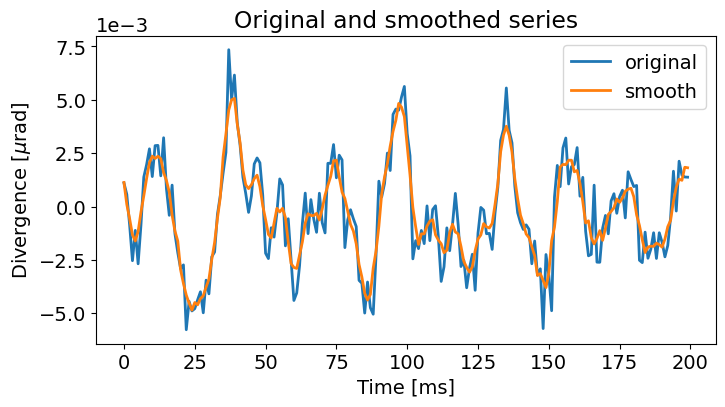

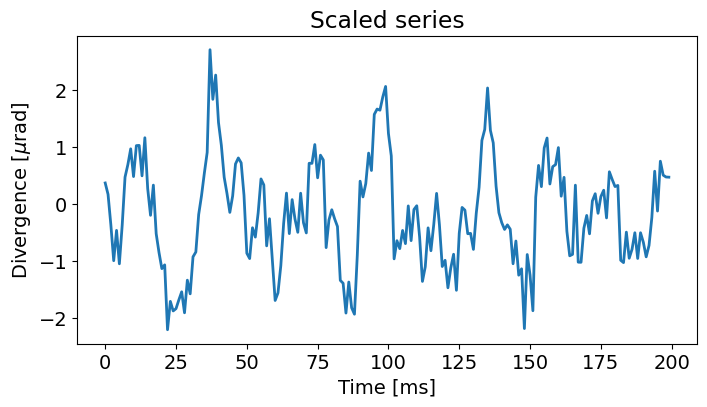

In [4]:
# Check series and its smoothed version
series = series_class.series
series_smooth = series_class.series_smooth

start, end = 100, 300
plt.figure()
plt.plot(series[start:end], label='original')
plt.plot(series_smooth[start:end], label='smooth')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
plt.xlabel('Time [ms]')
plt.ylabel('Divergence [$\mu$rad]')
plt.title('Original and smoothed series')
plt.legend()
plt.show()

# Check scaled series
train = series_class.train
test = series_class.test

start, end = 100, 300
plt.figure()
plt.plot(train[start:end], label='scaled')
plt.xlabel('Time [ms]')
plt.ylabel('Divergence [$\mu$rad]')
plt.title('Scaled series')
plt.show()

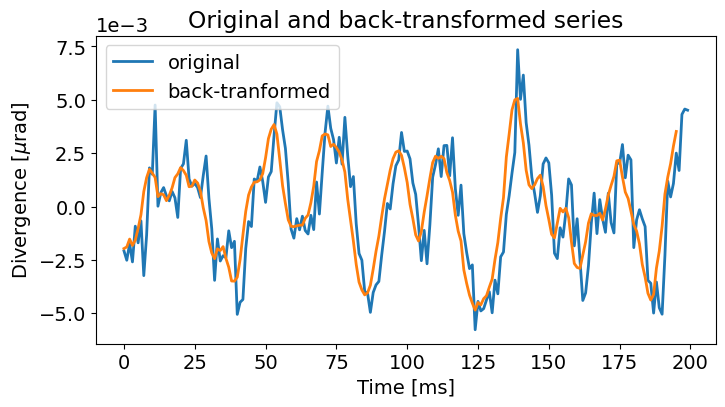

In [5]:
# One can transform data:
# 1) original series -> suitable as input to NN
# 2) NN prediction -> original scale

sample = ts_data[:200]
sample_nn, sample_smooth_nn = series_class.transform_series(sample)
sample_recovered = series_class.inverse_transform_series(sample_smooth_nn)

# Due to smoothing which cuts the boundary regions of time-series, the original
# and back-transformed series look shifted
plt.figure()
plt.plot(sample, label='original')
plt.plot(sample_recovered, label='back-tranformed')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
plt.xlabel('Time [ms]')
plt.ylabel('Divergence [$\mu$rad]')
plt.title('Original and back-transformed series')
plt.legend()
plt.show()

In [6]:
# create dataloaders for NN (this is what needed for training and accuracy evaluation)

training_window = 300
prediction_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 128,
    'drop_last': False,
}

loaders = series_class.create_dataloaders(series_class.train,
                                          series_class.test,
                                          sequence_params, dataloader_params)
trainloader, testloader = loaders

loaders = series_class.create_dataloaders(series_class.train_smooth,
                                          series_class.test_smooth,
                                          sequence_params, dataloader_params)
trainloader_smooth, testloader_smooth = loaders

print(f'Trainloader length: {len(trainloader_smooth)}')
print(f'Testloader length:  {len(testloader_smooth)}')

for x,y in trainloader_smooth:
    print(f'Input shape:  {x.shape}')
    print(f'Target shape: {y.shape}')
    break

Trainloader length: 122
Testloader length:  29
Input shape:  torch.Size([128, 300, 1])
Target shape: torch.Size([128, 100, 1])


### Model class usage

In [32]:
# For the model training and inference we need dataloaders provided by the 
# appropriate data class
n_features = 1
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

n_hidden_lstm = 64
model_params = {
    'n_features': n_features,
    'n_hidden_lstm': n_hidden_lstm,
    'n_hidden_fc': 1000,
    'n_outputs': prediction_window*n_features,
    'n_out_features': 1,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = f'models/rnn_temporal_tw_{training_window}_pw_{prediction_window}_hidlstm_{n_hidden_lstm}/'
load_model = False

In [33]:
# High-level model can be created by passing appropriate model_params without 
# model itself or with actual model

# Without model
model_high_level = RNNTemporal(model_params, None, save_folder)

# With model
model = LSTMForecaster(**model_params).to(device)
model_high_level = RNNTemporal(model_params, model, save_folder)

In [34]:
# Whenever high-level model is created, its parameters are saved to .yml file
# to its save directory for tractability. Be careful to use the same save folder
# because model_params.yml would be overwritten
yaml_file = glob.glob(f'{save_folder}*.yml')[0]
print(yaml_file)

model_params = read_yaml(yaml_file)
print(model_params)

models/rnn_temporal_tw_300_pw_100_hidlstm_64/model_params.yml
{'dropout': 0.2, 'n_deep_layers': 1, 'n_features': 1, 'n_hidden_fc': 1000, 'n_hidden_lstm': 64, 'n_lstm_layers': 2, 'n_out_features': 1, 'n_outputs': 100, 'sequence_len': 300, 'use_cuda': True}


In [35]:
# Each high-level model has following methods: train, predict, inference_on_dataloader,
# predict_on_series

# Training model uses dataloaders and saves `best model` to its save folder from which it
# could be later loaded with model.load_best_model()

# Define training parameters
lr = 1e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

# train the model
losses = model_high_level.train(trainloader_smooth, testloader_smooth,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.5294997909518538, valid: 0.27131292069780416
1 - train: 0.25077329270663806, valid: 0.23740597069263458
2 - train: 0.2262550770747857, valid: 0.21656152169252263
3 - train: 0.21305772869801912, valid: 0.20713313900191208
4 - train: 0.20402600396363463, valid: 0.1972019885634554
5 - train: 0.19540642556108412, valid: 0.19201907823825703
6 - train: 0.19002595653787988, valid: 0.18701314643539232
7 - train: 0.1839409553613819, valid: 0.18274684378813053
8 - train: 0.17724356018617504, valid: 0.1783973739064973
9 - train: 0.16908029308084582, valid: 0.1738659282182825
10 - train: 0.16057923130813193, valid: 0.16717511595323167
11 - train: 0.15163049785817256, valid: 0.16362016802204066
12 - train: 0.14246436562694487, valid: 0.16049206256866455
13 - train: 0.13409694632301566, valid: 0.15735325011713752
14 - train: 0.12538408775065765, valid: 0.15558746636941514
15 - train: 0.11707614637056335, valid: 0.15678724338268413
16 - train: 0.10887084486054592, valid: 0.15591386782711

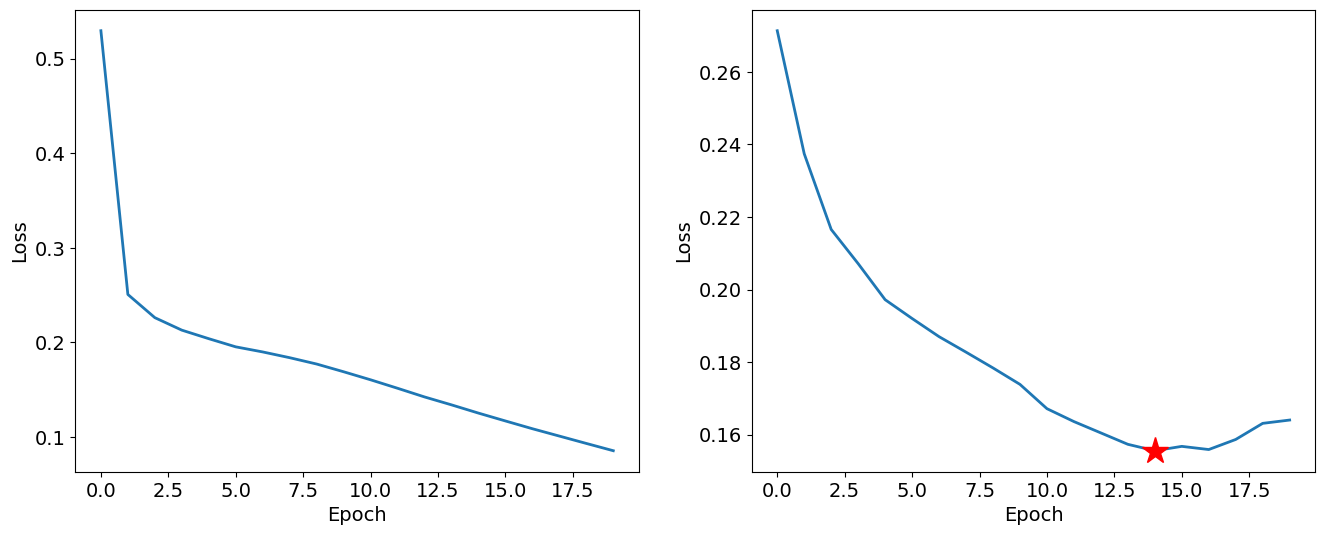

In [36]:
# Look at the training curves, star corresponds to the best performance on the train set
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if i == 1:
        idx = np.argmin(losses[1])
        plt.plot(idx, losses[1][idx], '*', color='red', ms=20)
plt.show()

In [37]:
# update the model in high-level model class to its best variant
model_high_level.load_best_model() 

LSTMForecaster(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=19200, out_features=1000, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dnn): Sequential(
    (0): ReLU()
    (1): Linear(in_features=1000, out_features=100, bias=True)
  )
)

In [38]:
# Inference on testloaders
data, metrics = model_high_level.inference_on_dataloader(testloader, series_class,
                                                         testloader_smooth)
predictions, actuals, actuals_smooth = data

Shapes: (3600, 100), (3600, 100)
MAE: 0.001072316779755056
RMS: 0.001320723444223404


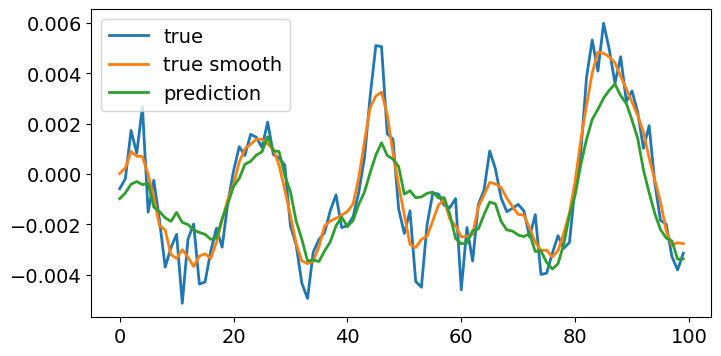

In [39]:
print(f'Shapes: {predictions.shape}, {actuals.shape}')
print(f'MAE: {metrics[0]}')
print(f'RMS: {metrics[1]}')

# an example of prediction
idx = 2000
plt.figure()
plt.plot(actuals[idx], label='true')
plt.plot(actuals_smooth[idx], label='true smooth')
plt.plot(predictions[idx], label='prediction')
plt.legend()
plt.show()

In [40]:
# Compare inference time for model on CPU/GPU
# Step 1: create models on CPU/GPU
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params_local = model_params.copy()
    model_params_local['use_cuda'] = use_cuda

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNTemporal(model_params_local, model, save_folder, load_model=True)
    models.append(model_high_level)

In [41]:
# Step 2: choose time-series slice
t0 = 17500
N = 5

past_start, past_end = t0-N//2, t0+training_window+N//2 
future_start, future_end = t0+training_window+N//2, t0+training_window+N//2+prediction_window
series_past = series_class.series[past_start:past_end].squeeze()
series_future = series_class.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, series_class, device=device)
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 46.5 ms
Prediction time (cuda): 1.9 ms


rms (initial): 0.0020630453994035128
rms          : 0.001492308605604865


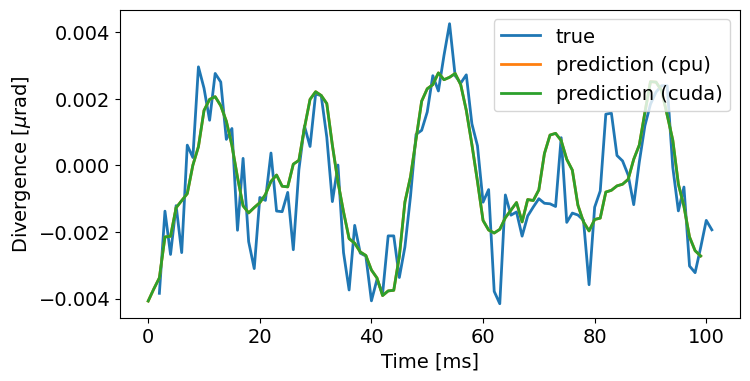

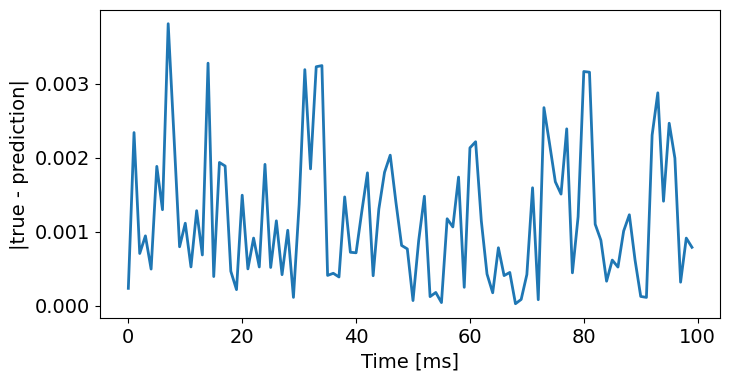

In [42]:
# Step 3: observe the results
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(prediction_window)+2, series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.xlabel('Time [ms]')
plt.ylabel('Divergence [$\mu$rad]')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.xlabel('Time [ms]')
plt.ylabel('|true - prediction|')
plt.show()

## STFT models

![](figures/stft_model.png)

The idea is to convert temporal signal with STFT to spectrogram with time-frequency information, use `training_window` past time steps to predict `prediction_window` future time steps for real and imaginary part of dominant frequency bands (the amplitude of which over period of time is large enough compared to the mean value). Since the number of input features is larger than in temporal case (this is no longer univariate time-series forecasting), we have a choice how many models we would use for the forecasting of all features. Available choices (all models use the same data class):
1. One model for all. Predicts both real and imag part of dominant frequency bands.
2. One model for real part of all frequency bands, one model for imag part.
3. Separate model for each frequency band's real/imag part.

### Data class usage

In [47]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

# parameters to filter out 'dominant' frequency bands from the spectrogram,
# 'thresh_weight' is weight multiplied by the mean amplitude of all frequency bands
# 'freq_low' is low frequency boundary from which we conssider frequency bands
# for prediction
filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}
scaling = 'standard'

# N = 5
# smooth_params = {
#     'kernel': np.ones(N)/N,
# }
smooth_params = None

# This data class automatically splits data to train/test, calculates stft of it,
# filters out not dominant frequeny bands and applies scaling. Optionally one can
# apply smoothing beforehand to the time-series
series_class = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8,
                              filter_params=filter_params, scaling=scaling,
                              smooth_params=smooth_params)

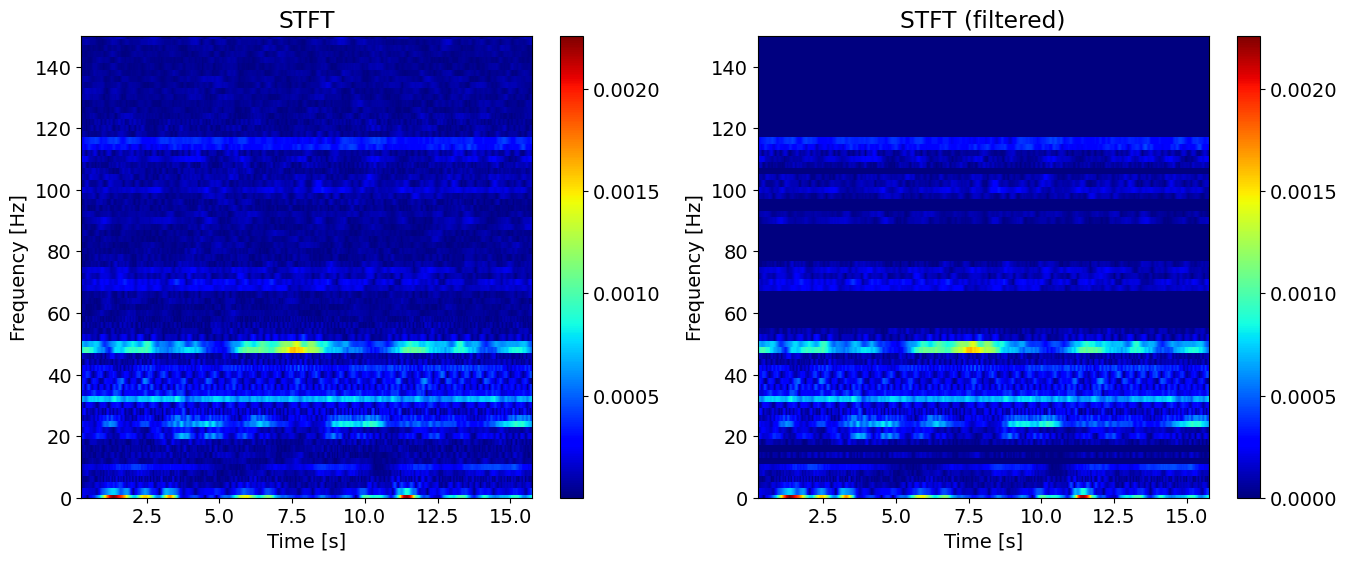

In [48]:
# take a look at the spectrogram and its filtered version (some of the bands are 
# zeroed out)
t, freq, spectrum = series_class.t, series_class.freq, series_class.train_stft
spectrum_filt = series_class.train_stft_filt

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(t, freq, np.abs(spectrum), cmap='jet')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT')

plt.subplot(122)
plt.pcolormesh(t, freq, np.abs(spectrum_filt), cmap='jet')
plt.colorbar()
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim([0,150])
plt.title('STFT (filtered)')
plt.show()

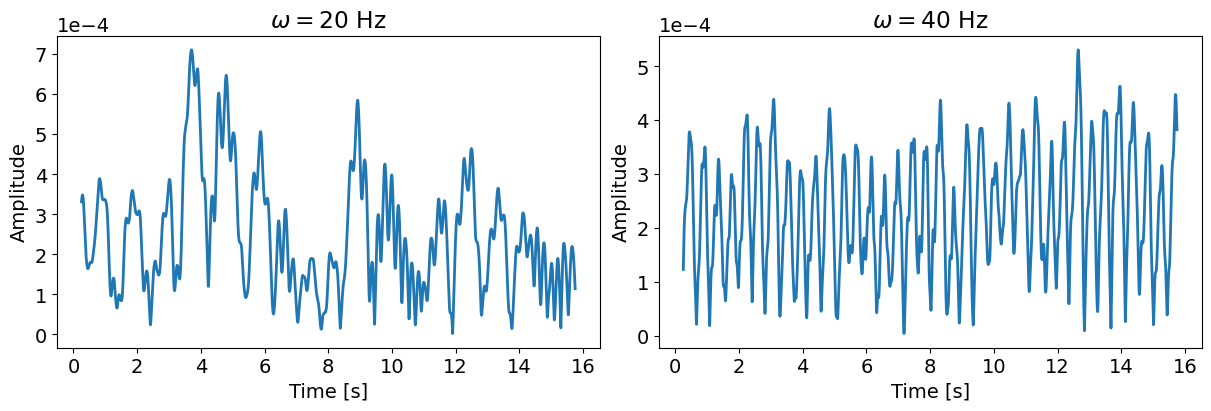

In [49]:
# Plot the variation of amplitude for some frequency bands
idxs = [10, 20]
n = len(idxs)
plt.figure(figsize=(n*6,4), layout='constrained')
for i in range(n):
    plt.subplot(1,n,i+1)
    plt.plot(t, np.abs(spectrum[idxs[i]]))
    plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('$\\omega = {:2.0f}$ Hz'.format(freq[idxs[i]]))
plt.show()

Shapes:  (600,) (101, 84) (600,)


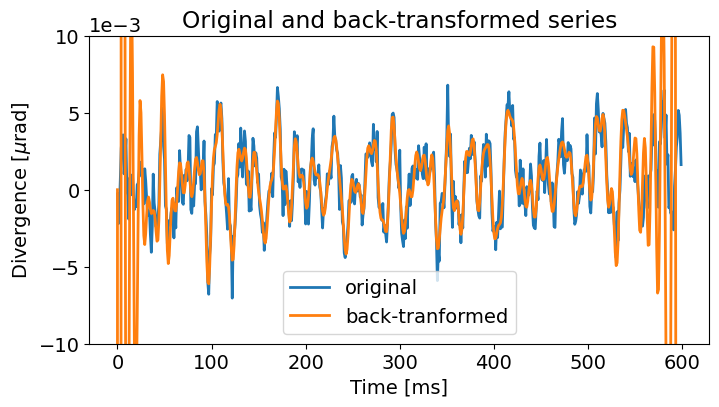

In [50]:
# Compare original and back-transformed signal
start, end = 500, 1100
sample = ts_data[start:end]
sample_transformed = series_class.transform_series(sample)
sample_recovered = series_class.inverse_transform_series(sample_transformed)
print('Shapes: ', sample.shape, sample_transformed.shape, sample_recovered.shape)

# Since we zero out some of the frequency bands, we do not reconstruct the original 
# signal fully, the problems are especially noticeable for boundary region
plt.figure()
plt.plot(sample, label='original')
plt.plot(sample_recovered, label='back-tranformed')
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
plt.ylim([-10e-3,10e-3])
plt.xlabel('Time [ms]')
plt.ylabel('Divergence [$\mu$rad]')
plt.title('Original and back-transformed series')
plt.legend()
plt.show()

In [56]:
training_window = 400
prediction_window = 200
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = series_class.create_dataloaders(series_class.train_real, series_class.train_imag,
                                          series_class.test_real, series_class.test_imag,
                                          sequence_params, dataloader_params)
trainloader, testloader = loaders

print(f'Trainloader length: {len(trainloader)}')
print(f'Testloader length:  {len(testloader)}')

for x, y in trainloader:
    print(f'Input shape:  {x.shape}')
    print(f'Target shape: {y.shape}')
    break

Trainloader length: 233
Testloader length:  46
Input shape:  torch.Size([64, 400, 84])
Target shape: torch.Size([64, 200, 84])


### Single model class

In [57]:
n_features = len(series_class.freq_filt)*2
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

n_hidden_lstm = 64
n_hidden_fc = 1000
model_params = {
    'n_features': n_features,
    'n_hidden_lstm': n_hidden_lstm,
    'n_hidden_fc': n_hidden_fc,
    'n_outputs': prediction_window*n_features,
    'n_out_features': n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = f'models/rnn_stft_tw_{training_window}_pw_{prediction_window}_hidlstm_{n_hidden_lstm}_hidfc_{n_hidden_fc}/'
load_model = False
# load_model = True

model = LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT(model_params, model, save_folder, load_model)

cuda


In [ ]:
# Define training parameters
lr = 1e-4
n_epochs = 15

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

# train the model
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.604786625491703, valid: 0.39014119914044504


In [ ]:
# Look at the training curves, star corresponds to the best performance on the train set
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    if i == 1:
        idx = np.argmin(losses[1])
        plt.plot(idx, losses[1][idx], '*', color='red', ms=20)
plt.show()

In [ ]:
# update the model in high-level model class to its best variant
model_high_level.load_best_model() 

In [ ]:
# Inference on test series
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

data, metrics = model_high_level.inference_on_dataloader(test, series_class,
                                                         sequence_params,
                                                         dataloader_params,
                                                         forecast_window)
predictions, actuals = data

In [ ]:
print(f'Shapes: {predictions.shape}, {actuals.shape}')
print(f'MAE: {metrics[0]}')
print(f'RMS: {metrics[1]}')

# an example of prediction
idx = 2000
plt.figure()
plt.plot(actuals[idx], label='true')
plt.plot(predictions[idx], label='prediction')
plt.legend()
plt.show()

In [ ]:
# Compare inference time for model on CPU/GPU
# Step 1: create models on CPU/GPU
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params_local = model_params.copy()
    model_params_local['use_cuda'] = use_cuda

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT(model_params_local, model, save_folder, load_model=True)
    models.append(model_high_level)

In [ ]:
# Step 2: choose time-series slice
t0 = 17500
window_len = stft_params['noverlap']

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = series_class.series[past_start:past_end].squeeze()
series_future = series_class.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

In [ ]:
# Step 3: observe the results
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

### Two models (real/imag)
For other model classes the usage is the same (same dataloaders used for train and same methods). One just needs to specify needed model class and correct number of input features.

### Model ensemble